In [1]:
import torch
from torchinfo import summary
import torch.optim as optim
from torch.nn import MSELoss
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader


from utils.metrics import validation_scores
from models.completion.VAE import ConditionalVAE
from utils.datasets import MNIST_SR_completion
from utils.utils import gaussian_kl


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
num_epochs = 100
batch_size = 512
scalefactor = 4

path = f"trained_models/VAE_MNIST_{scalefactor}x_completion_mse.pth"

latent_dims = [64]
condition_dims = [32, 64]
channels = [16, 32, 64, 128]
cond_channels = [16, 32]
in_channels = 1
cond_base_width = 32 // scalefactor
model = ConditionalVAE(in_channels=in_channels,
                          latent_dims=latent_dims,
                          channels=channels,
                          cond_channels=cond_channels,
                          condition_dims=condition_dims,
                          cond_base_width=cond_base_width
                          ).to(device)
print(model.sample(torch.randn(1, in_channels, cond_base_width, cond_base_width).to(device)).shape)
summary(model, input_size=[(1, in_channels, 32, 32), (1, in_channels, cond_base_width, cond_base_width), (1, in_channels, 32, 32)])

torch.Size([1, 1, 32, 32])


Layer (type:depth-idx)                   Output Shape              Param #
ConditionalVAE                           [1, 1, 32, 32]            3
├─ConditionalVAEEncoder: 1-1             [1, 64]                   --
│    └─Conv2d: 2-1                       [1, 16, 32, 32]           32
│    └─Conv2d: 2-2                       [1, 32, 16, 16]           8,224
│    └─Conv2d: 2-3                       [1, 64, 8, 8]             32,832
│    └─Conv2d: 2-4                       [1, 128, 4, 4]            131,200
│    └─Linear: 2-5                       [1, 64]                   131,136
│    └─Linear: 2-6                       [1, 64]                   131,136
├─ConditionalVAELREncoder: 1-2           [1, 32]                   --
│    └─Conv2d: 2-7                       [1, 16, 8, 8]             32
│    └─Conv2d: 2-8                       [1, 32, 4, 4]             8,224
│    └─Linear: 2-9                       [1, 32]                   16,416
│    └─Linear: 2-10                      [1, 64]         

In [3]:
train_dataset = MNIST_SR_completion(scale_factor=scalefactor, split='train')
test_dataset = MNIST_SR_completion(scale_factor=scalefactor, split='test')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
num_train_data = len(train_dataset)
print(f"Dataset Loaded: {len(train_dataset)} training samples, {len(test_dataset)} validation samples")

Dataset Loaded: 60000 training samples, 10000 validation samples


In [4]:
# Adam opt
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = MSELoss()
# Learning Rate Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.9)

In [5]:
loss_list = []
recon_loss_list = []
kl_loss_list = []
val_loss_list = []
val_recon_loss_list = []
val_kl_loss_list = []

In [6]:
kl_weight = 1000

for epoch in range(num_epochs):
    total_loss = 0
    total_recon_loss = 0
    total_kl_loss = 0
    total_val_loss = 0
    total_val_recon_loss = 0
    total_val_kl_loss = 0

    for HR, LR, LR_up in train_loader:
        model.train()
        optimizer.zero_grad()

        recon_imgs, latents = model(HR, LR, LR_up)

        recon_loss = criterion(recon_imgs, HR)
        kl_loss = 0
        for mu, logvar in latents:
            kl_loss += torch.mean(gaussian_kl(mu, logvar, torch.zeros_like(mu), torch.zeros_like(logvar)))
        loss = recon_loss + kl_weight * kl_loss

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_recon_loss += recon_loss.item()
        total_kl_loss += kl_loss.item()

    scheduler.step()

    if (epoch) % 10 == 0 or epoch == num_epochs-1:
        model.eval()
        with torch.no_grad():
            for HR, LR, LR_up in val_loader:
                recon_imgs, latents = model(HR, LR, LR_up)
                recon_loss = criterion(recon_imgs, HR)
                kl_loss = 0
                for mu, logvar in latents:
                    kl_loss += torch.mean(gaussian_kl(mu, logvar, torch.zeros_like(mu), torch.zeros_like(logvar)))
                loss = recon_loss + kl_weight * kl_loss

                total_val_loss += loss.item()
                total_val_recon_loss += recon_loss.item()
                total_val_kl_loss += kl_loss.item()

        total_val_loss /= len(val_loader)
        total_val_recon_loss /= len(val_loader)
        total_val_kl_loss /= len(val_loader)
        print(f"Validation Epoch [{epoch+1}/{num_epochs}] | Loss: {total_val_loss:.6f} | Recon Loss: {total_val_recon_loss:.6f} | KL Loss: {total_val_kl_loss:.6f}")
        val_loss_list.append(total_val_loss)
        val_recon_loss_list.append(total_val_recon_loss)
        val_kl_loss_list.append(total_val_kl_loss)

    total_loss /= len(train_loader)
    total_recon_loss /= len(train_loader)
    total_kl_loss /= len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {total_loss:.6f} | Recon Loss: {total_recon_loss:.6f} | KL Loss: {total_kl_loss:.6f}")
    loss_list.append(total_loss)
    recon_loss_list.append(total_recon_loss)
    kl_loss_list.append(total_kl_loss)

Validation Epoch [1/100] | Loss: 0.038363 | Recon Loss: 0.016758 | KL Loss: 0.000022
Epoch [1/100] | Loss: 0.628019 | Recon Loss: 0.025866 | KL Loss: 0.000602
Epoch [2/100] | Loss: 0.026258 | Recon Loss: 0.010959 | KL Loss: 0.000015
Epoch [3/100] | Loss: 0.015123 | Recon Loss: 0.006560 | KL Loss: 0.000009
Epoch [4/100] | Loss: 0.010989 | Recon Loss: 0.005178 | KL Loss: 0.000006
Epoch [5/100] | Loss: 0.008857 | Recon Loss: 0.004537 | KL Loss: 0.000004
Epoch [6/100] | Loss: 0.007503 | Recon Loss: 0.004131 | KL Loss: 0.000003
Epoch [7/100] | Loss: 0.006541 | Recon Loss: 0.003840 | KL Loss: 0.000003
Epoch [8/100] | Loss: 0.006054 | Recon Loss: 0.003625 | KL Loss: 0.000002
Epoch [9/100] | Loss: 0.005396 | Recon Loss: 0.003479 | KL Loss: 0.000002
Epoch [10/100] | Loss: 0.004939 | Recon Loss: 0.003325 | KL Loss: 0.000002
Validation Epoch [11/100] | Loss: 0.004540 | Recon Loss: 0.003246 | KL Loss: 0.000001
Epoch [11/100] | Loss: 0.004647 | Recon Loss: 0.003218 | KL Loss: 0.000001
Epoch [12/100

In [7]:
torch.save(model.state_dict(), path)

In [4]:
model.load_state_dict(torch.load(path))

<All keys matched successfully>

[]

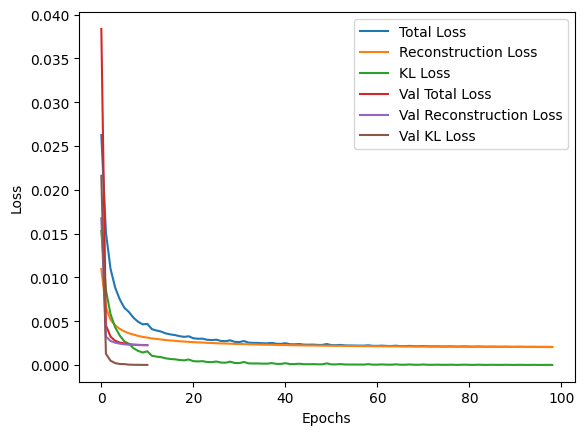

In [9]:
plt.plot(loss_list[1:], label='Total Loss')
plt.plot(recon_loss_list[1:], label='Reconstruction Loss')
plt.plot([l * kl_weight for l in kl_loss_list][1:], label='KL Loss')
plt.plot(val_loss_list, label='Val Total Loss')
plt.plot(val_recon_loss_list, label='Val Reconstruction Loss')
plt.plot([l * kl_weight for l in val_kl_loss_list], label='Val KL Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot()

In [5]:
HR, LR, LR_up = test_dataset.get_samples(1000)
SR = model.sample(LR)

In [11]:
def show_image(x, low_res, superres, n):

    fig, axs = plt.subplots(3, n, figsize=(20, 6))
    for i in range(n):
        #figure description above every row in the middle
        if i == 0:
            axs[0, i].set_title('Original')
            axs[1, i].set_title('Low Resolution')
            axs[2, i].set_title('Super Resolution')

        axs[0, i].imshow(x[i].permute(1, 2, 0).detach().cpu().numpy(),)
        axs[0, i].axis('off')

        axs[1, i].imshow(low_res[i].permute(1, 2, 0).detach().cpu().numpy())
        axs[1, i].axis('off')

        axs[2, i].imshow(superres[i].permute(1, 2, 0).detach().cpu().numpy())
        axs[2, i].axis('off')

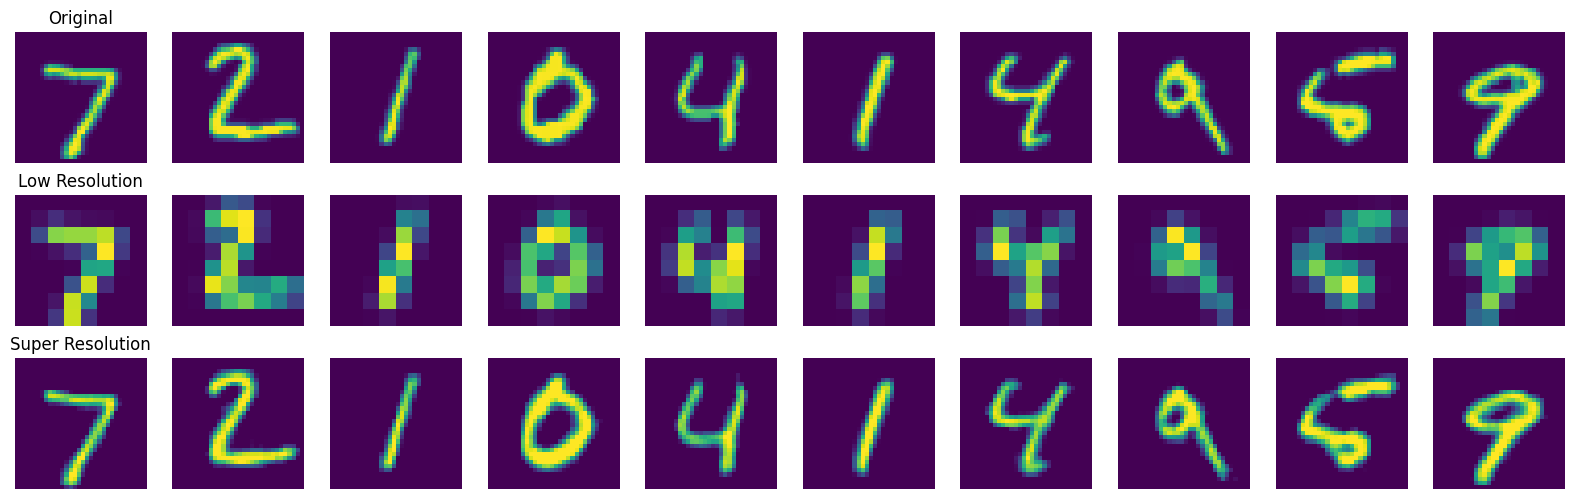

In [12]:
show_image(HR, LR, SR, 10)

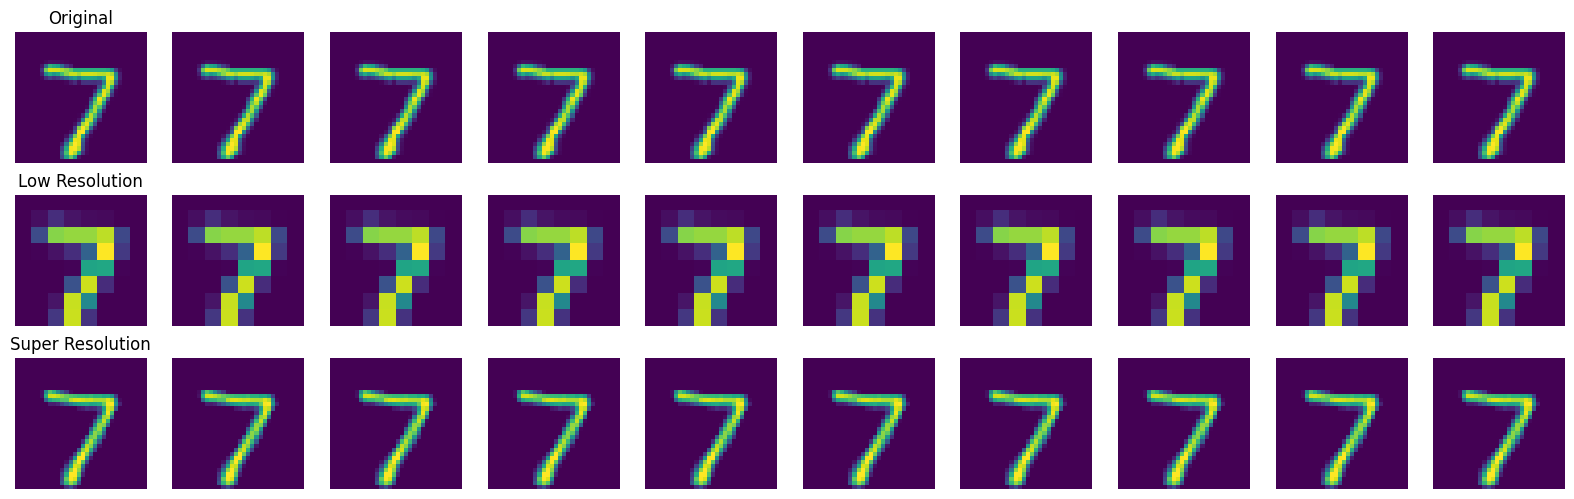

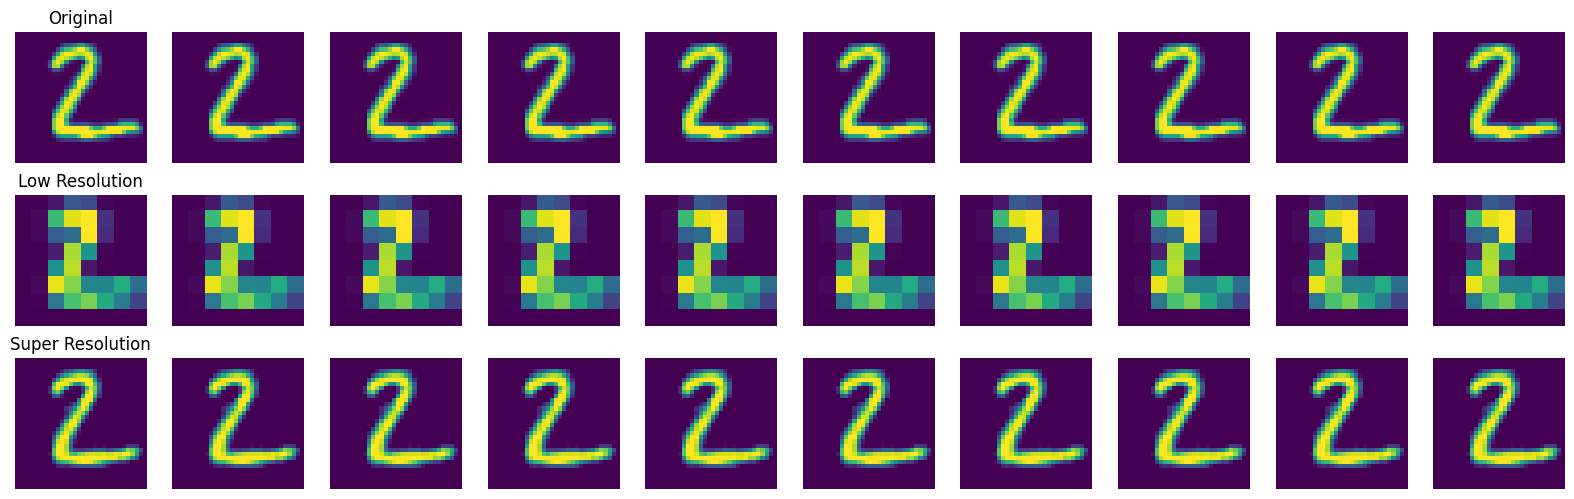

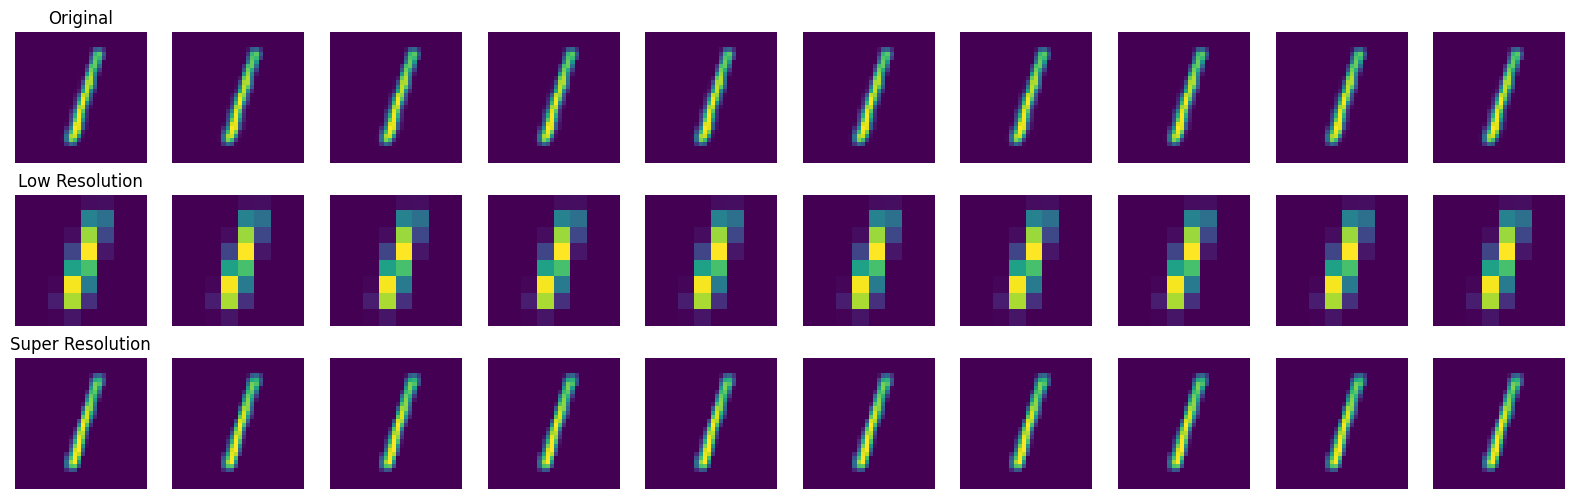

In [13]:
n_samp = 3

for i in range(n_samp):
    reference = HR[i]
    reference = reference.repeat(batch_size, 1, 1, 1)
    reference_inp = LR[i].unsqueeze(0).repeat(batch_size, 1, 1, 1)
    
    samples = model.sample(reference_inp).detach().cpu()

    show_image(reference, reference_inp, samples, 10)

In [7]:
mse_val, perceptual_val, psnr_val, ssim_val, lpips_val, brisque_val, psnr_consistency_val, mse_diversity_val, lpips_diversity_val = validation_scores(model, HR, LR)
print("MSE:", mse_val)
print("Perceptual:", perceptual_val)
print("PSNR:", psnr_val)
print("SSIM:", ssim_val)
print("LPIPS:", lpips_val)
print("BRISQUE:", brisque_val)
print("PSNR Consistency:", psnr_consistency_val)
print("MSE Diversity:", mse_diversity_val)
print("LPIPS Diversity:", lpips_diversity_val)

c:\Users\maxhe\anaconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\maxhe\anaconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MSE: 0.0022605343256145716
Perceptual: 0.5750706195831299
PSNR: 27.355791091918945
SSIM: 0.9660036563873291
LPIPS: 0.028687547892332077
BRISQUE: 68.75531768798828
PSNR Consistency: 40.76761245727539
MSE Diversity: 1.2968999757445587e-06
LPIPS Diversity: 2.153913553470943e-05
